# Loading Data

Original data source: https://www.kaggle.com/datasnaek/league-of-legends

The original data had all champion and spell id's encoded as numbers, with separate json files for the actual names and other info.  I have already extracted those names to make the data more human-readable, and will be trying different methods of encoding in my models.

In [9]:
# Loading files locally
%cd LoL_project

import pandas as pd
train = pd.read_csv('LoL_train_cleaned.csv', index_col=0)
val = pd.read_csv('LoL_val_cleaned.csv', index_col=0)
champ_stats = pd.read_csv('champ_stats.csv', index_col=0)

[WinError 2] The system cannot find the file specified: 'LoL_project'
C:\Users\thedo\LoL_project


In [10]:
print(train.shape)
train.head()

(36043, 61)


,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
22656,3214824413,0,1274,9,2,2,2,2,0,2,...,10,2,0,2,1,Katarina,Yasuo,Lucian,Zac,Darius
17347,3214843995,2392998,2033,9,1,2,1,1,2,1,...,6,0,1,3,1,Zac,Camille,Galio,Draven,Xayah
9978,3214825708,3633614,2087,9,1,2,2,1,1,2,...,4,0,0,2,1,Vladimir,Ivern,Galio,Fizz,Fiora
34410,3214844763,4917497,2323,9,1,1,2,1,2,2,...,3,0,1,2,0,Zac,Fiora,Yasuo,Lulu,Fizz
10658,3214864950,6643444,1613,9,2,1,1,2,2,1,...,6,1,1,1,0,Zyra,Kassadin,Xayah,Katarina,Ivern


In [11]:
# These stats were calculated based on matches in the train and validation sets
# (aside from best_role, which was looked up)
champ_stats.head()

,pick_count,ban_count,pick_rate,ban_rate,win_rate,dragon_kill_rate,baron_kill_rate,best_role
name,,,,,,,,
Tristana,10982,10247,0.250925,0.234132,0.515025,1.398106,0.410126,ADC
Thresh,11197,5014,0.255838,0.114564,0.472895,1.401000,0.398857,Support
Vayne,8916,7410,0.203720,0.169310,0.514581,1.369897,0.407470,ADC
Kayn,8204,14601,0.187451,0.333615,0.485982,1.281326,0.352511,Jungle
Lee Sin,7929,5570,0.181168,0.127268,0.525918,1.460840,0.391222,Jungle


### Champ Stats data dictionary

pick_count - number of times this champion was picked in a game

ban_count - number of times this champion was banned in a game

pick_rate - percentage of all games where this champion is picked

ban_rate - percentage of all games where this champion is banned

win_rate - how often this champion's team wins when it is picked

dragon_kill_rate - the average number of times this champion's team kills the dragon

baron_kill_rate - the average number of times this champion's team kills the baron

best_role - the most commonly used role for this champion recorded by [champion.gg](https://champion.gg/)

# Data Exploration and Visualizations

In [0]:
# imports and setup
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

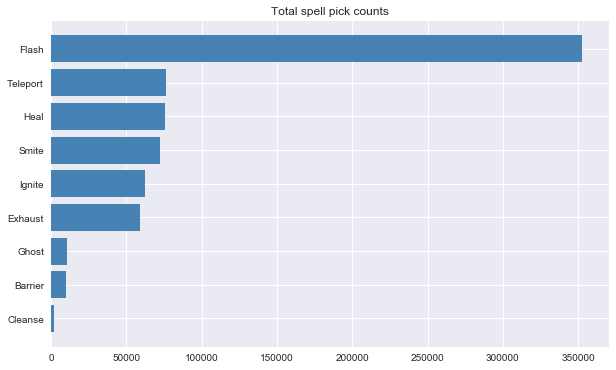

In [13]:
# Most common spells used
columns = train.columns
spell_cols = columns[columns.str.contains('sum')].tolist()
spell_counts = train[spell_cols[0]].value_counts()
for i in range(1, len(spell_cols)):
  spell_counts += train[spell_cols[i]].value_counts()

spell_counts = spell_counts.sort_values()

plt.figure(figsize=(10,6))
plt.barh(y=spell_counts.index, width=spell_counts, color='steelblue')
plt.title('Total spell pick counts');

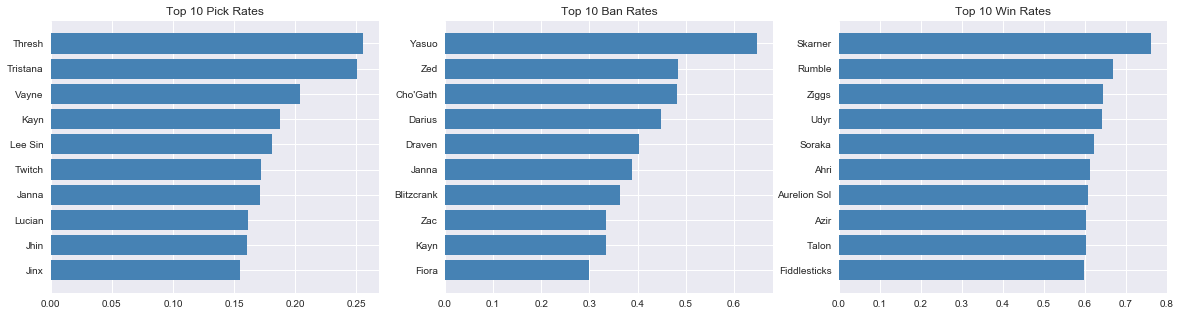

In [14]:
# Top 10 champion lists
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,5)

sorted_df = champ_stats.sort_values('pick_rate')[-10:]
ax[0].barh(y=sorted_df.index, width=sorted_df['pick_rate'], color='steelblue')
ax[0].set_title('Top 10 Pick Rates')

sorted_df = champ_stats.sort_values('ban_rate')[-10:]
ax[1].barh(y=sorted_df.index, width=sorted_df['ban_rate'], color='steelblue')
ax[1].set_title('Top 10 Ban Rates')

sorted_df = champ_stats.sort_values('win_rate')[-10:]
ax[2].barh(y=sorted_df.index, width=sorted_df['win_rate'], color='steelblue')
ax[2].set_title('Top 10 Win Rates');

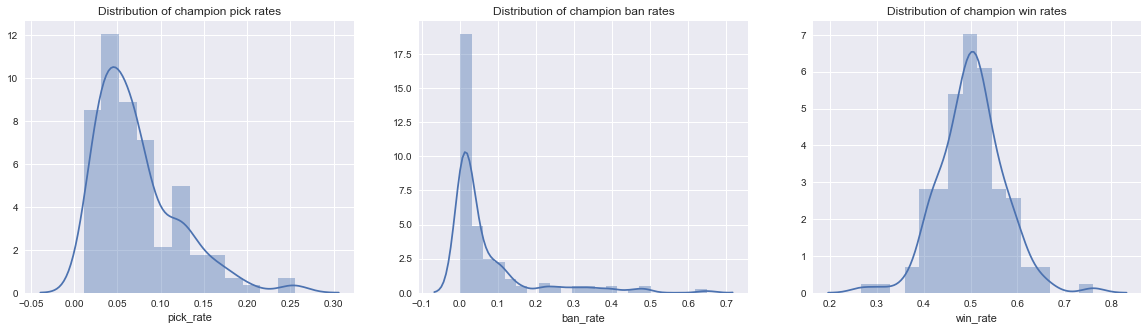

In [15]:
# Visualize distribution of champion stats
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,5)

sns.distplot(champ_stats['pick_rate'], ax=ax[0])
ax[0].set_title('Distribution of champion pick rates')

sns.distplot(champ_stats['ban_rate'], ax=ax[1])
ax[1].set_title('Distribution of champion ban rates')

sns.distplot(champ_stats['win_rate'], ax=ax[2])
ax[2].set_title('Distribution of champion win rates');

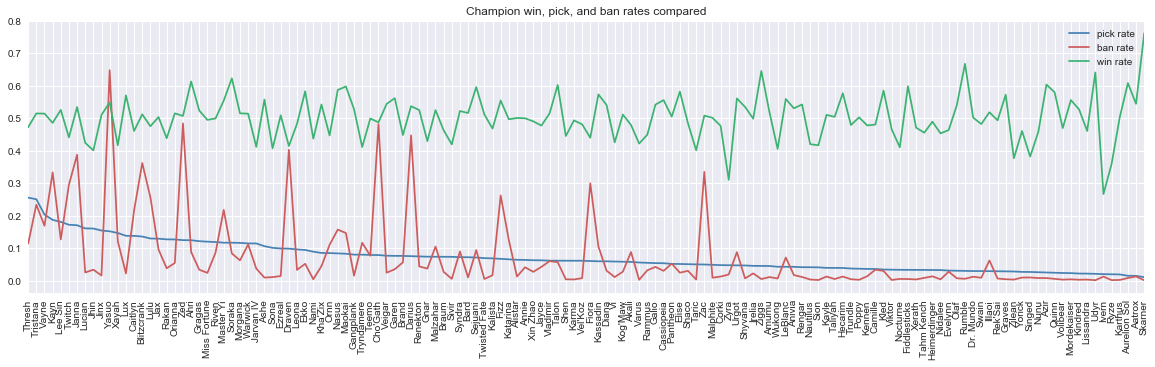

In [16]:
plt.figure(figsize=(20,5))
sorted_df = champ_stats.sort_values('pick_rate', ascending=False)
plt.plot(sorted_df.index, sorted_df['pick_rate'], 
         color='steelblue', label='pick rate')
plt.plot(sorted_df.index, sorted_df['ban_rate'], 
         color='indianred', label='ban rate')
plt.plot(sorted_df.index, sorted_df['win_rate'], 
         color='mediumseagreen', label='win rate')
plt.legend()
plt.title('Champion win, pick, and ban rates compared')
plt.xticks(rotation=90)
plt.margins(x=0);

# Feature Engineering

In [0]:
# My feature engineering code
# Since this has to calculate some things by individual rows, 
# it might take a bit to run

# Save lists of top 10 champions
top_picks = champ_stats.sort_values('pick_rate', ascending=False)[:10].index
top_bans = champ_stats.sort_values('ban_rate', ascending=False)[:10].index

# helpers
def count_commons(a, b): 
  """ returns the number of common values between arrays a & b """
  return len(set(a) & set(b))

def is_meta(team):
  """ 
  A "meta" team is one that includes one champion from each of the five roles.
  Returns true if the team has one of each role, false otherwise.
  """
  return champ_stats.loc[team]['best_role'].nunique() == 5

# main function
def engineer_features(X):
  """ returns X with new engineered features """
  X = X.copy()

  # calculating 8 new columns for each row:
  new_col = [.0] * len(X) # initialize with floats

  # average win rate for champs on each team (mean of win rates)
  X['t1_avg_win_rate'] = new_col
  X['t2_avg_win_rate'] = new_col

  # average ban rate for champs on each team 
  # (this is particularly interesting, since it tells how often 
  # the champs picked in this game were banned in others)
  X['t1_avg_ban_rate'] = new_col
  X['t2_avg_ban_rate'] = new_col

  # average kill rates for each team's champs of each monster
  X['t1_avg_dragon_kills'] = new_col
  X['t2_avg_dragon_kills'] = new_col
  X['t1_avg_baron_kills'] = new_col
  X['t2_avg_baron_kills'] = new_col

  # number of top 10 champs on each team
  new_col = [0] * len(X) # these columns will be integer types
  X['t1_top_picks'] = new_col
  X['t2_top_picks'] = new_col
  X['t1_top_bans'] = new_col
  X['t2_top_bans'] = new_col

  # checking team composition
  new_col = [False] * len(X)
  X['t1_is_meta'] = new_col
  X['t2_is_meta'] = new_col

  for i in X.index:
    # extract team lists
    team1 = X.loc[i][['t1_champ1id', 't1_champ2id', 't1_champ3id', 
                      't1_champ4id', 't1_champ5id']]
    team2 = X.loc[i][['t2_champ1id', 't2_champ2id', 't2_champ3id', 
                      't2_champ4id', 't2_champ5id']]

    # average stats of the 5 champs on each team
    t1_stats = champ_stats.loc[team1].mean()
    X.at[i, 't1_avg_win_rate'] = t1_stats['win_rate']
    X.at[i, 't1_avg_ban_rate'] = t1_stats['ban_rate']
    X.at[i, 't1_avg_dragon_kills'] = t1_stats['dragon_kill_rate']
    X.at[i, 't1_avg_baron_kills'] = t1_stats['baron_kill_rate']

    t2_stats = champ_stats.loc[team2].mean()
    X.at[i, 't2_avg_win_rate'] = t2_stats['win_rate']
    X.at[i, 't2_avg_ban_rate'] = t2_stats['ban_rate']
    X.at[i, 't2_avg_dragon_kills'] = t2_stats['dragon_kill_rate']
    X.at[i, 't2_avg_baron_kills'] = t2_stats['baron_kill_rate']

    # count number of top 10 champs
    X.at[i, 't1_top_picks'] = count_commons(team1, top_picks)
    X.at[i, 't2_top_picks'] = count_commons(team2, top_picks)
    X.at[i, 't1_top_bans'] = count_commons(team1, top_bans)
    X.at[i, 't2_top_bans'] = count_commons(team2, top_bans)

    X.at[i, 't1_is_meta'] = is_meta(team1)
    X.at[i, 't2_is_meta'] = is_meta(team2)


  # Also find the difference between those average rates
  X['win_rate_delta'] = X['t1_avg_win_rate'] - X['t2_avg_win_rate']
  X['ban_rate_delta'] = X['t1_avg_ban_rate'] - X['t2_avg_ban_rate']
  X['dragon_delta'] = X['t1_avg_dragon_kills'] - X['t2_avg_dragon_kills']
  X['baron_delta'] = X['t1_avg_baron_kills'] - X['t2_avg_baron_kills']
  X['top_picks_delta'] = X['t1_top_picks'] - X['t2_top_picks']
  X['top_bans_delta'] = X['t1_top_bans'] - X['t2_top_bans']

  return X

In [18]:
%%time
# apply feature engineering
train = engineer_features(train)
val = engineer_features(val)

Wall time: 6min 4s


In [19]:
# view the engineered columns
train[train.columns[-20:]].head()

,t1_avg_win_rate,t2_avg_win_rate,t1_avg_ban_rate,t2_avg_ban_rate,t1_avg_dragon_kills,t2_avg_dragon_kills,t1_avg_baron_kills,t2_avg_baron_kills,t1_top_picks,t2_top_picks,t1_top_bans,t2_top_bans,t1_is_meta,t2_is_meta,win_rate_delta,ban_rate_delta,dragon_delta,baron_delta,top_picks_delta,top_bans_delta
22656,0.517458,0.444778,0.191523,0.058082,1.397779,1.371932,0.392861,0.370357,1,2,2,0,True,False,0.072680,0.133441,0.025847,0.022504,-1,2
17347,0.500740,0.507390,0.105721,0.016739,1.399765,1.399125,0.395659,0.407894,2,0,0,0,True,False,-0.006650,0.088982,0.000640,-0.012234,2,0
9978,0.513434,0.515845,0.020477,0.134095,1.424480,1.418066,0.387844,0.398913,0,3,0,0,True,True,-0.002411,-0.113618,0.006414,-0.011069,-3,0
34410,0.477560,0.469466,0.105858,0.038962,1.396970,1.458763,0.399061,0.420391,0,2,1,0,True,True,0.008094,0.066897,-0.061793,-0.021330,-2,1
10658,0.480455,0.528259,0.308034,0.118540,1.397505,1.324792,0.387148,0.392188,3,1,2,1,False,True,-0.047804,0.189494,0.072713,-0.005040,2,1


### Visualizations of engineered features

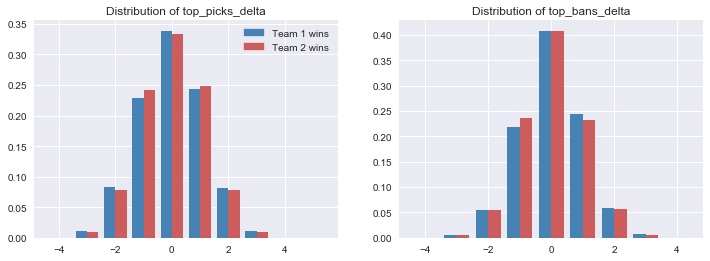

In [20]:
# Distribution of the integer deltas
wins1 = train[train['winner'] == 1]
wins2 = train[train['winner'] == 2]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,4)

cols = ['top_picks_delta', 'top_bans_delta']
for i in range(2):
  val1 = wins1[cols[i]].value_counts(normalize=True)
  ax[i].bar(x=val1.index-.2, height=val1, width=.4, 
            color='steelblue', label='team 1 wins')
  
  val2 = wins2[cols[i]].value_counts(normalize=True)
  ax[i].bar(x=val2.index+.2, height=val2, width=.4, 
            color='indianred', label='team 2 wins')
  ax[i].set_title('Distribution of ' + cols[i])

# draw legend
from matplotlib.patches import Rectangle
legend_elements = [Rectangle([0,0], 0, 0, color='steelblue'),
                   Rectangle([0,0], 0, 0, color='indianred')]
ax[0].legend(legend_elements, ['Team 1 wins', 'Team 2 wins']);

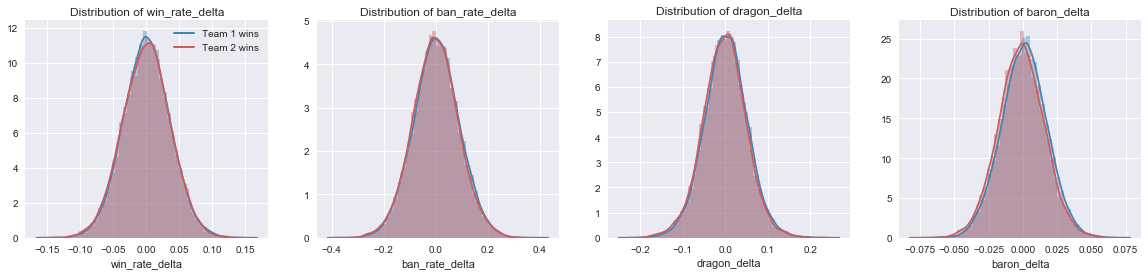

In [21]:
# visualizations of the other delta columns
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20,4)

# pick columns for each graph
cols = ['win_rate_delta', 'ban_rate_delta', 'dragon_delta', 'baron_delta']

# plot all 6 graphs
for i in range(4):
    sns.distplot(wins1[cols[i]], ax=ax[i], color='steelblue')
    sns.distplot(wins2[cols[i]], ax=ax[i], color='indianred')
    ax[i].set_title('Distribution of ' + cols[i])

# draw legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='steelblue', lw=2),
                   Line2D([0], [0], color='indianred', lw=2)]
ax[0].legend(legend_elements, ['Team 1 wins', 'Team 2 wins']);

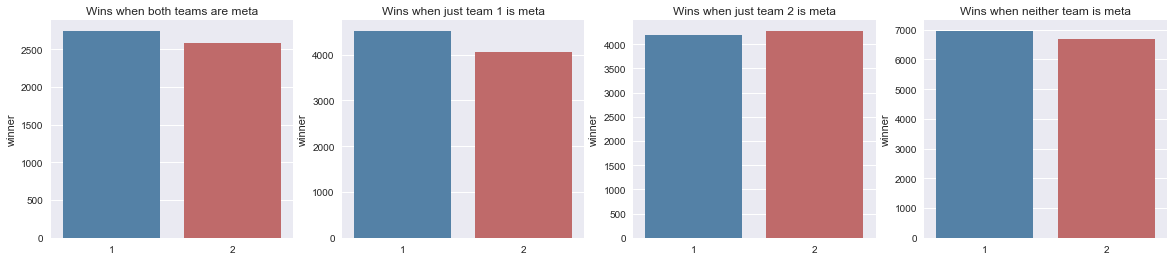

In [22]:
# Distribution of the meta columns
dists = [[],[],[],[]]
dists[0] = train[train['t1_is_meta'] & train['t2_is_meta']]['winner']   #both
dists[1] = train[train['t1_is_meta'] & ~train['t2_is_meta']]['winner']  #team1
dists[2] = train[~train['t1_is_meta'] & train['t2_is_meta']]['winner']  #team2
dists[3] = train[~train['t1_is_meta'] & ~train['t2_is_meta']]['winner'] #neither

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20,4)
palette = {'steelblue','indianred'}

sns.barplot(x=dists[0].value_counts().index, y=dists[0].value_counts(), 
            palette=palette, ax=ax[0])
ax[0].set_title('Wins when both teams are meta')

sns.barplot(x=dists[1].value_counts().index, y=dists[1].value_counts(), 
            palette=palette, ax=ax[1])
ax[1].set_title('Wins when just team 1 is meta')

sns.barplot(x=dists[2].value_counts().index, y=dists[2].value_counts(), 
            palette=palette, ax=ax[2])
ax[2].set_title('Wins when just team 2 is meta')

sns.barplot(x=dists[3].value_counts().index, y=dists[3].value_counts(), 
            palette=palette, ax=ax[3])
ax[3].set_title('Wins when neither team is meta');

# Models

In [23]:
# Majority baseline: 51%
train['winner'].value_counts(normalize=True)

1    0.511139
2    0.488861
Name: winner, dtype: float64

In [24]:
# Selecting Features
target = 'winner'
columns = train.columns
champs_used = columns[columns.str.contains('id')].tolist()
champs_banned = (columns[columns.str.contains('t1_ban')].tolist() +
                 columns[columns.str.contains('t2_ban')].tolist())
spells_used = columns[columns.str.contains('sum')].tolist()
engineered = columns[-20:].tolist()

# Using all available pre-match data plus my engineered features (should be 60)
all_features = champs_used + champs_banned + spells_used + engineered
print('Number of features selected:', len(all_features))

Number of features selected: 60


In [25]:
# Handpicking features I believe make the most sence, and to reduce redundancy
handpicked = champs_used + engineered[-8:]
handpicked

['t1_champ1id',
 't1_champ2id',
 't1_champ3id',
 't1_champ4id',
 't1_champ5id',
 't2_champ1id',
 't2_champ2id',
 't2_champ3id',
 't2_champ4id',
 't2_champ5id',
 't1_is_meta',
 't2_is_meta',
 'win_rate_delta',
 'ban_rate_delta',
 'dragon_delta',
 'baron_delta',
 'top_picks_delta',
 'top_bans_delta']

## Quick models with default hyperparameters

In [26]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Using all pre-match data
X_train = train[all_features]
y_train = train[target]
X_val = val[all_features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    LogisticRegression(max_iter=500)
)

pipeline.fit(X_train, y_train)
print('Logistic regression accuracy with all pre-match data:', 
      pipeline.score(X_val, y_val))

Logistic regression accuracy with all pre-match data: 0.5144373947947689


C:\Users\thedo\Anaconda3\envs\unit2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
# Using just the handpicked features
X_train = train[handpicked]
y_train = train[target]
X_val = val[handpicked]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    LogisticRegression()
)

pipeline.fit(X_train, y_train)
print('Logistic regression accuracy with handpicked data:', 
      pipeline.score(X_val, y_val))

Logistic regression accuracy with handpicked data: 0.516768095299754


C:\Users\thedo\Anaconda3\envs\unit2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
from sklearn.tree import DecisionTreeClassifier

# Using all pre-match data
X_train = train[all_features]
y_train = train[target]
X_val = val[all_features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier()
)

pipeline.fit(X_train, y_train)
print('Decision tree accuracy with all pre-match data:', 
      pipeline.score(X_val, y_val))

Decision tree accuracy with all pre-match data: 0.48582157192800723


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Using all pre-match data
X_train = train[all_features]
y_train = train[target]
X_val = val[all_features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('Random forest accuracy with all pre-match data:', 
      pipeline.score(X_val, y_val))

Random forest accuracy with all pre-match data: 0.508481160170918


In [30]:
# Using just the handpicked features
X_train = train[handpicked]
y_train = train[target]
X_val = val[handpicked]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('Random forest accuracy with handpicked data:', 
      pipeline.score(X_val, y_val))

Random forest accuracy with handpicked data: 0.5162501618542017


In [31]:
from xgboost import XGBClassifier

# Using all pre-match data
X_train = train[all_features]
y_train = train[target]
X_val = val[all_features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with all pre-match data:', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with all pre-match data: 0.5224653632008287


In [32]:
# Using just the handpicked features
X_train = train[handpicked]
y_train = train[target]
X_val = val[handpicked]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with handpicked data:', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with handpicked data: 0.5237601968147093


In [33]:
from sklearn.naive_bayes import GaussianNB

# Using all pre-match data
X_train = train[all_features]
y_train = train[target]
X_val = val[all_features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    GaussianNB()
)

pipeline.fit(X_train, y_train)
print('Gaussian Naive Bayes accuracy with all pre-match data:', 
      pipeline.score(X_val, y_val))

Gaussian Naive Bayes accuracy with all pre-match data: 0.523112780007769


In [34]:
from sklearn.naive_bayes import CategoricalNB

# Using just champions (this model can't use negative numbers?)
X_train = train[champs_used]
y_train = train[target]
X_val = val[champs_used]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    CategoricalNB()
)

pipeline.fit(X_train, y_train)
print('Categorical Naive Bayes accuracy with just champions used:', 
      pipeline.score(X_val, y_val))

Categorical Naive Bayes accuracy with just champions used: 0.529327981354396


## Trying various encoding methods

I used ordinal encoding above because by default it performed similarly to one-hot encoding wile taking a fraction of the time to run.  Since I have 20 champion columns (pick and ban) each with 138 cardinality, and 20 spell columns each with 9 cardinality, one-hot encoding is a very poor choice.

Check documentation for details on the different types of encoding: https://contrib.scikit-learn.org/categorical-encoding/index.html



In [35]:
# Without tuning hyperparameters, the different models above perform similarly
# Since XGBoost is traditionally a good model, I will use it to test encoders
from xgboost import XGBClassifier

# Attempting ordinal encoding with champions sorted by stats
sorted_stats = champ_stats['win_rate'].sort_values().to_dict()
mapping = []
for i in range(10):
  mapping.append({'col':champs_used[i],'mapping':sorted_stats})

# Using just the engineered features and champs used 
# (would need to add others to the mapping)
features = champs_used + engineered
X_train = train[features]
X_val = val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(mapping=mapping),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with OrdinalEncoder (sorted):', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with OrdinalEncoder (sorted): 0.5201346626958436


In [36]:
# Using all pre-match data
X_train = train[all_features]
y_train = train[target]
X_val = val[all_features]
y_val = val[target]

pipeline = make_pipeline(
    ce.TargetEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with TargetEncoder:', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with TargetEncoder: 0.5238896801760974


In [37]:
pipeline = make_pipeline(
    ce.LeaveOneOutEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with LeaveOneOutEncoder:', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with LeaveOneOutEncoder: 0.4970866243687686


In [38]:
pipeline = make_pipeline(
    ce.HelmertEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with HelmertEncoder:', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with HelmertEncoder: 0.5240191635374855


In [39]:
pipeline = make_pipeline(
    ce.CatBoostEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with CatBoostEncoder:', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with CatBoostEncoder: 0.5165091285769778


In [40]:
# Weight of evidence encoding requires the target to be a binary 0 or 1 value.
# My original target was either a 1 or 2, so just subtract 1
y_train_binary = y_train-1
y_val_binary = y_val-1

pipeline = make_pipeline(
    ce.WOEEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train_binary)
print('XGBoost accuracy with WOEEncoder:', 
      pipeline.score(X_val, y_val_binary))

XGBoost accuracy with WOEEncoder: 0.5255729638741422


In [41]:
pipeline = make_pipeline(
    ce.JamesSteinEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with JamesSteinEncoder:', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with JamesSteinEncoder: 0.5236307134533212


In [42]:
pipeline = make_pipeline(
    ce.MEstimateEncoder(),
    XGBClassifier(n_jobs=-3)
)

pipeline.fit(X_train, y_train)
print('XGBoost accuracy with MEstimateEncoder:', 
      pipeline.score(X_val, y_val))

XGBoost accuracy with MEstimateEncoder: 0.5222063964780526


So none of the 7 encoding methods tried here stands out by much, unfortunately.

## Try everything at once

And put the results into handy tables

In [63]:
# NOTE: this code cell fits 192 possible feature/encoder/model combinations
#       it will take a while to run

import numpy as np

# Logistic Regression usually fails to converge, hide that warning's output
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Clone models and encoders each loop so they aren't fit from the previous runs
from sklearn import clone

# Combinations to try
possible_features = [all_features,
                     handpicked,
                     champs_used,
                     engineered]
models = [LogisticRegression(max_iter=500),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          XGBClassifier(),
          GaussianNB(),
          CategoricalNB()]
encoders = [ce.OrdinalEncoder(),
            ce.TargetEncoder(),
            ce.LeaveOneOutEncoder(),
            ce.HelmertEncoder(),
            ce.CatBoostEncoder(),
            ce.WOEEncoder(),
            ce.JamesSteinEncoder(),
            ce.MEstimateEncoder()]

model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 
               'XGBoost', 'GaussianNB', 'CategoricalNB']
encoder_names = ['OrdinalEncoder', 'TargetEncoder', 'LeaveOneOutEncoder', 
                 'HelmertEncoder', 'CatBoostEncoder', 'WOEEncoder', 
                 'JamesSteinEncoder', 'MEstimateEncoder']
model_results = [] # array to store each of the 4 feature combinations

# use the binary target so WOEEncoder works correctly, 
# other models will still work the same
y_train_binary = train[target]-1
y_val_binary = val[target]-1

for f in range(len(possible_features)):
  print('Fitting combinations on features:', possible_features[f])
  # set up X matrices for the features in this loop
  X_train = train[possible_features[f]]
  X_val = val[possible_features[f]]

  results = pd.DataFrame([],columns=model_names)
  for e in range(len(encoders)):
    row = []
    for m in range(len(models)):
      # try this model/encoder combo
      try:
        pipeline = make_pipeline(clone(encoders[e]), clone(models[m]))
        pipeline.fit(X_train, y_train_binary)
        score = pipeline.score(X_val, y_val_binary)
      except ValueError: # some combinations do not work together
        score = np.nan
      
      # add this model's score to the new row
      row.append(score)

    # save the row
    results = results.append(pd.DataFrame([row], columns=model_names))

  # save encoder names to index to mark the rows
  results['encoders'] = encoder_names
  results = results.set_index('encoders')

  # save this dataframe to the array
  model_results.append(results)

Fitting combinations on features: ['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id', 't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5_sum1', 't1_champ5_sum2', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5_sum1', 't2_champ5_sum2', 't1_avg_win_rate', 't2_avg_win_rate', 't1_avg_ban_rate', 't2_avg_ban_rate', 't1_avg_dragon_kills', 't2_avg_dragon_kills', 't1_avg_baron_kills', 't2_avg_baron_kills', 't1_top_picks', 't2_top_picks', 't1_top_bans', 't2_top_bans', 't1_is_meta', 't2_is_meta', 'win_rate_delta', 'ban_rate_delta', 'dragon_delta', 'baron_delta', 'top_picks_delta', 'to

In [64]:
# Results with all features
model_results[0]

,LogisticRegression,DecisionTree,RandomForest,XGBoost,GaussianNB,CategoricalNB
encoders,,,,,,
OrdinalEncoder,0.514437,0.489447,0.507057,0.522465,0.523113,NaN
TargetEncoder,0.522724,0.505244,0.528551,0.524019,0.525961,NaN
LeaveOneOutEncoder,0.529198,0.494238,0.497087,0.497087,0.522077,NaN
HelmertEncoder,0.526220,0.511071,0.503949,0.524019,0.511589,NaN
CatBoostEncoder,0.524537,0.504726,0.514437,0.517804,0.522465,NaN
WOEEncoder,0.523760,0.511200,0.518710,0.525573,0.526738,NaN
JamesSteinEncoder,0.526479,0.510812,0.528422,0.523631,0.527774,NaN
MEstimateEncoder,0.522595,0.508093,0.520264,0.522206,0.524926,NaN


In [65]:
# Results with my handpicked features
model_results[1]

,LogisticRegression,DecisionTree,RandomForest,XGBoost,GaussianNB,CategoricalNB
encoders,,,,,,
OrdinalEncoder,0.517933,0.510035,0.515603,0.523760,0.523890,NaN
TargetEncoder,0.531529,0.518192,0.523631,0.526868,0.532695,NaN
LeaveOneOutEncoder,0.535284,0.499288,0.503302,0.499417,0.532565,NaN
HelmertEncoder,0.530364,0.507057,0.508611,0.522983,0.521429,NaN
CatBoostEncoder,0.527515,0.499547,0.513143,0.521818,0.530623,NaN
WOEEncoder,0.532177,0.509647,0.519358,0.524537,0.532695,NaN
JamesSteinEncoder,0.532954,0.508222,0.520523,0.527515,0.532177,NaN
MEstimateEncoder,0.531659,0.510682,0.520653,0.526868,0.532824,NaN


In [66]:
# Results with just the champions picked
model_results[2]

,LogisticRegression,DecisionTree,RandomForest,XGBoost,GaussianNB,CategoricalNB
encoders,,,,,,
OrdinalEncoder,0.498122,0.503043,0.517027,0.518063,0.497864,0.529328
TargetEncoder,0.528292,0.507834,0.516768,0.525832,0.526997,0.497087
LeaveOneOutEncoder,0.524278,0.501230,0.497087,0.498640,0.524278,0.497087
HelmertEncoder,0.531011,0.497993,0.515991,0.508481,0.520912,NaN
CatBoostEncoder,0.526091,0.504208,0.508352,0.520653,0.519228,0.497087
WOEEncoder,0.528292,0.504726,0.514696,0.524408,0.527774,0.497087
JamesSteinEncoder,0.528681,0.498770,0.520653,0.521818,0.526868,0.497087
MEstimateEncoder,0.527774,0.500583,0.522854,0.524408,0.527904,0.497087


In [67]:
# Results with just the engineered features
# I realized afterwards that since these features are entirely numeric, the
# encoders don't matter.  Only randomness in the models changed any scores.
model_results[3]

,LogisticRegression,DecisionTree,RandomForest,XGBoost,GaussianNB,CategoricalNB
encoders,,,,,,
OrdinalEncoder,0.520005,0.503949,0.517804,0.520135,0.528033,NaN
TargetEncoder,0.520005,0.500324,0.512366,0.520135,0.528033,NaN
LeaveOneOutEncoder,0.520005,0.498899,0.512884,0.520135,0.528033,NaN
HelmertEncoder,0.520005,0.506409,0.515603,0.520135,0.528033,NaN
CatBoostEncoder,0.520005,0.505115,0.511071,0.520135,0.528033,NaN
WOEEncoder,0.520005,0.499288,0.514437,0.520135,0.528033,NaN
JamesSteinEncoder,0.520005,0.494626,0.511330,0.520135,0.528033,NaN
MEstimateEncoder,0.520005,0.499547,0.505115,0.520135,0.528033,NaN


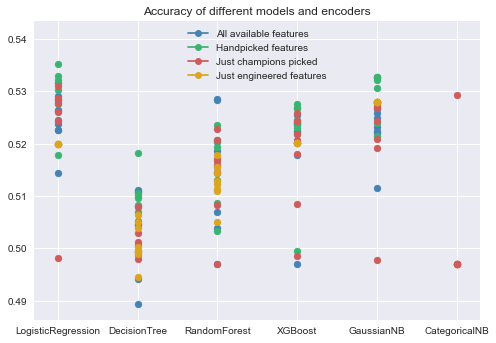

In [68]:
colors = ['steelblue', 'mediumseagreen', 'indianred', 'goldenrod']
for i in range(len(model_results)):
  for col in model_results[i].columns:
    data = model_results[i][col]
    plt.scatter(x=[col] * len(data), y=data, color=colors[i], label=colors[i])

plt.title('Accuracy of different models and encoders');

# draw legend (not perfect, but I need plotly instead for the final graphic)
legend_names = ['All available features', 'Handpicked features', 
                'Just champions picked', 'Just engineered features']
legend_elements = [Line2D([0], [0], marker='o', color=colors[0]),
                   Line2D([0], [0], marker='o', color=colors[1]),
                   Line2D([0], [0], marker='o', color=colors[2]),
                   Line2D([0], [0], marker='o', color=colors[3])]
plt.legend(legend_elements, legend_names);

In [0]:
# That same graph, but with plotly for interactivity
import plotly.graph_objects as go

fig = go.Figure()

legend_names = ['All available features', 'Handpicked features', 
                'Just champions picked', 'Just engineered features']
colors = ['steelblue', 'mediumseagreen', 'indianred', 'goldenrod']
for i in range(len(model_results)):
  legend = True
  for col in model_results[i].columns:
    data = model_results[i][col]
    mark = go.scatter.Marker(color=colors[i], size=8)
    fig.add_trace(go.Scatter(x=[col] * len(data), y=data, mode='markers', 
                             marker=mark, text=model_results[i].index, 
                             name=legend_names[i], showlegend=legend, 
                             hoverinfo='x+y+text'))
    legend = False

fig.update_layout(
    title='Accuracies of different models, encoders, and feature sets',
    autosize=False, width=800, height=500,
    xaxis_title="Classification Model", yaxis_title="Accuracy")
fig.show()

## Hyperparameter optimization and cross-validation

### Logistic Regression with LeaveOneOutEncoder

This was my best result using default hyperparameters

In [98]:
from sklearn.model_selection import GridSearchCV

# Handpicked features, combined for cross-validation
X_trainval = train[handpicked].append(val[handpicked])
y_trainval = train[target].append(val[target])

LR_pipeline = make_pipeline(
    ce.LeaveOneOutEncoder(),
    LogisticRegression(max_iter=500)
)

LR_parameters = {                                                  # defaults:
    'leaveoneoutencoder__sigma': [None,.05,.1,.3,.6],           # None
    'logisticregression__C': [.5,1.0,1.5],                      # 1.0
    'logisticregression__solver': ['lbfgs','liblinear','saga']  # lbfgs
}

LR_search = GridSearchCV(
    LR_pipeline, 
    param_grid = LR_parameters,
    cv=5, 
    scoring='accuracy', 
    verbose=10,
    n_jobs=-3
)

LR_search.fit(X_trainval, y_trainval);

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-3)]: Done  41 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-3)]: Done  52 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-3)]: Done  65 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-3)]: Done  78 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-3)]: Done  93 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-3)]: Done 108 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-3)]: Done 125 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-3)]: Done 142 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-3)]: Done 161 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-3)]: Done 201 tasks      | elapsed:  

In [99]:
# View the best model found
print('Best hyperparameters:', LR_search.best_params_)
print('Cross-validation accuracy score:', LR_search.best_score_)

Best hyperparameters: {'leaveoneoutencoder__sigma': None, 'logisticregression__C': 1.5, 'logisticregression__solver': 'lbfgs'}
Cross-validation accuracy score: 0.5369695526043214


### Random Forest Classifier with JamesSteinEncoder

In [46]:
X_trainval = train[handpicked].append(val[handpicked])
y_trainval = train[target].append(val[target])

RF_pipeline = make_pipeline(
    ce.JamesSteinEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-3)
)

RF_parameters = {                                                  # defaults:
    'jamessteinencoder__sigma': [0.05,0.5,1.0,1.5,2.0],         # 0.05
    'randomforestclassifier__n_estimators': range(50, 251, 50), # 100
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None]  # None
}

RF_search = GridSearchCV(
    RF_pipeline, 
    param_grid = RF_parameters,
    cv=5, 
    scoring='accuracy', 
    verbose=10,
    n_jobs=-3
)

RF_search.fit(X_trainval, y_trainval);

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-3)]: Done  41 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-3)]: Done  52 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-3)]: Done  65 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-3)]: Done  78 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-3)]: Done  93 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-3)]: Done 108 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-3)]: Done 125 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-3)]: Done 142 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-3)]: Done 161 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-3)]: Done 201 tasks      | elapsed:  

In [47]:
# View the best model found
print('Best hyperparameters:', RF_search.best_params_)
print('Cross-validation accuracy score:', RF_search.best_score_)

Best hyperparameters: {'jamessteinencoder__sigma': 0.05, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 250}
Cross-validation accuracy score: 0.5321941410289931


### Gaussian Naive-Bayes with MEstimateEncoder

This model outperformed Random Forest and XGBoost models with most encoders

In [48]:
X_trainval = train[handpicked].append(val[handpicked])
y_trainval = train[target].append(val[target])

GNB_pipeline = make_pipeline(
    ce.MEstimateEncoder(),
    GaussianNB()
)

GNB_parameters = {                                          # defaults:
    'mestimateencoder__m': [0.5,1.0,1.5,2.0],           # 1.0
    'gaussiannb__var_smoothing': [0,1e-9,1e-6,1e-3,.1]  # 1e-9
}

GNB_search = GridSearchCV(
    GNB_pipeline, 
    param_grid = GNB_parameters,
    cv=5, 
    scoring='accuracy', 
    verbose=10,
    n_jobs=-3
)

GNB_search.fit(X_trainval, y_trainval);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-3)]: Done  41 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-3)]: Done  52 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-3)]: Done  65 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-3)]: Done  78 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-3)]: Done  92 out of 100 | elapsed:    8.0s remaining:    0.6s
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:    8.4s finished


In [49]:
# View the best model found
print('Best hyperparameters:', GNB_search.best_params_)
print('Cross-validation accuracy score:', GNB_search.best_score_)

Best hyperparameters: {'gaussiannb__var_smoothing': 0, 'mestimateencoder__m': 2.0}
Cross-validation accuracy score: 0.5343190562739533


### CategoricalNB with OrdinalEncoder

This combination got a high accuracy with just the champions used, no engineering.

In [50]:
X_trainval = train[champs_used].append(val[champs_used])
y_trainval = train[target].append(val[target])

CNB_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    CategoricalNB()
)

# Not many parameter options in this one
CNB_parameters = {                                    # defaults:
    'categoricalnb__alpha': [0,0.5,1.0,1.5,2.0]   # 1.0
}

CNB_search = GridSearchCV(
    CNB_pipeline, 
    param_grid = CNB_parameters,
    cv=5, 
    scoring='accuracy', 
    verbose=10,
    n_jobs=-3
)

CNB_search.fit(X_trainval, y_trainval);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-3)]: Done   9 out of  25 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=-3)]: Done  12 out of  25 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-3)]: Done  15 out of  25 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-3)]: Done  18 out of  25 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-3)]: Done  21 out of  25 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-3)]: Done  25 out of  25 | elapsed:    1.3s finished
C:\Users\thedo\Anaconda3\envs\unit2\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [51]:
# View the best model found
print('Best hyperparameters:', CNB_search.best_params_)
print('Cross-validation accuracy score:', CNB_search.best_score_)

Best hyperparameters: {'categoricalnb__alpha': 0}
Cross-validation accuracy score: 0.5321940914360221


### CatBoost

From https://catboost.ai/

In [0]:
%%capture
conda install -c conda-forge catboost

In [53]:
from catboost import CatBoostClassifier

X_train = train[all_features]
y_train = train[target]
X_val = val[all_features]
y_val = val[target]
cat_features = champs_used + champs_banned + spells_used

# No need for a pipeline, this model doesn't require encoding
model = CatBoostClassifier(
    loss_function='Logloss',  # Logloss is default, also the best result I got
    custom_metric='Accuracy', # Accuracy is not an available loss function, but can be reported this way
    max_depth=6,              # default is 6
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,  # have to specify which features are categorical
    eval_set=(X_val, y_val),
    early_stopping_rounds=100,  # runs 1000 iterations if not stopped
)

Learning rate set to 0.076815
0:	learn: 0.6929062	test: 0.6930387	best: 0.6930387 (0)	total: 199ms	remaining: 3m 19s
1:	learn: 0.6925688	test: 0.6929110	best: 0.6929110 (1)	total: 351ms	remaining: 2m 55s
2:	learn: 0.6922505	test: 0.6927329	best: 0.6927329 (2)	total: 492ms	remaining: 2m 43s
3:	learn: 0.6919627	test: 0.6925384	best: 0.6925384 (3)	total: 616ms	remaining: 2m 33s
4:	learn: 0.6917046	test: 0.6924299	best: 0.6924299 (4)	total: 752ms	remaining: 2m 29s
5:	learn: 0.6915894	test: 0.6924017	best: 0.6924017 (5)	total: 790ms	remaining: 2m 10s
6:	learn: 0.6913296	test: 0.6923108	best: 0.6923108 (6)	total: 926ms	remaining: 2m 11s
7:	learn: 0.6910150	test: 0.6922552	best: 0.6922552 (7)	total: 1.06s	remaining: 2m 11s
8:	learn: 0.6907928	test: 0.6922317	best: 0.6922317 (8)	total: 1.2s	remaining: 2m 11s
9:	learn: 0.6905816	test: 0.6921097	best: 0.6921097 (9)	total: 1.36s	remaining: 2m 14s
10:	learn: 0.6903162	test: 0.6920864	best: 0.6920864 (10)	total: 1.51s	remaining: 2m 15s
11:	learn: 0

In [54]:
# Best accuracy
model.best_score_

{'learn': {'Accuracy': 0.6552173792414616, 'Logloss': 0.6516871133588958},
 'validation': {'Accuracy': 0.5267383141266347, 'Logloss': 0.6913293840685848}}

## Model Visualizations

### Confusion Matrices

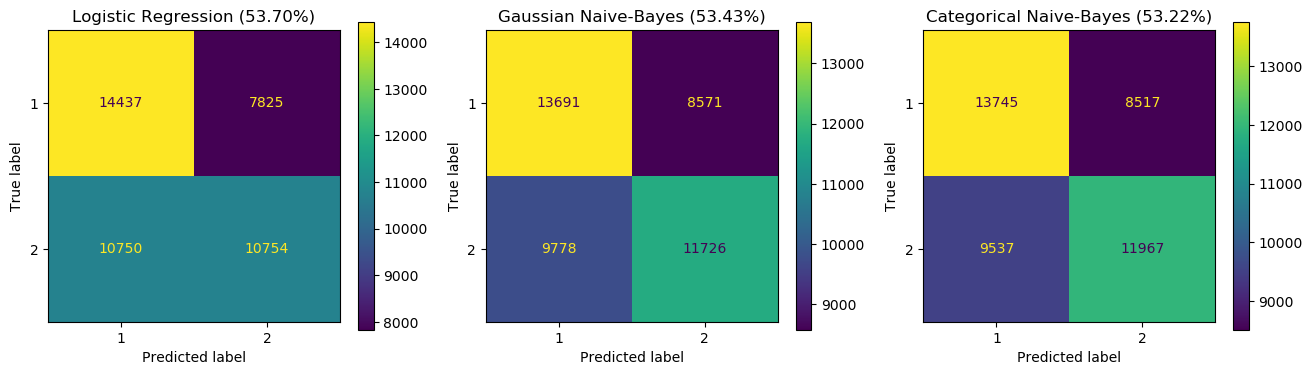

In [92]:
# Confusion matrices for each of the 3 top models
from sklearn.metrics import plot_confusion_matrix
plt.style.use('default') # reset seaborn style (white grids overlaid it)

fig, ax = plt.subplots(1,3)
fig.set_size_inches(16,4)

X_trainval = train[handpicked].append(val[handpicked])
plot_confusion_matrix(LR_search.best_estimator_, X_trainval, y_trainval, 
                      values_format='.0f', ax=ax[0]);
ax[0].set_title(f'Logistic Regression ({LR_search.best_score_*100:.02f}%)')

plot_confusion_matrix(GNB_search.best_estimator_, X_trainval, y_trainval, 
                      values_format='.0f', ax=ax[1]);
ax[1].set_title(f'Gaussian Naive-Bayes ({GNB_search.best_score_*100:.02f}%)')

X_trainval = train[champs_used].append(val[champs_used])
plot_confusion_matrix(CNB_search.best_estimator_, X_trainval, y_trainval, 
                      values_format='.0f', ax=ax[2]);
ax[2].set_title(f'Categorical Naive-Bayes ({CNB_search.best_score_*100:.02f}%)');

### Feature coefficients

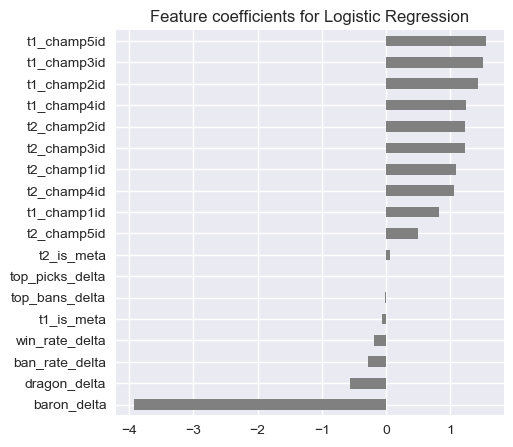

In [125]:
# Get and plot feature importances
plt.style.use('seaborn') # change back
model = LR_search.best_estimator_.named_steps['logisticregression']
importances = pd.Series(model.coef_[0], handpicked)

plt.figure(figsize=(5,5))
plt.title(f'Feature coefficients for Logistic Regression')
importances.sort_values()[-n:].plot.barh(color='grey');

### Permutation importance

In [100]:
# Showing permutation importance, just for one model
import eli5
from eli5.sklearn import PermutationImportance
X_train = train[handpicked]
X_val = val[handpicked]

# Encode
encoder = clone(LR_search.best_estimator_.named_steps['leaveoneoutencoder'])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)

# Copy and fit the model
model = clone(LR_search.best_estimator_.named_steps['logisticregression'])
model.fit(X_train_encoded, y_train)

# Fit a permuter
permuter = PermutationImportance(model, scoring='accuracy',
                                 n_iter=5, random_state=42)
permuter.fit(X_val_encoded, y_val)

# Display permutation importances
feature_names = X_val.columns.to_list()
eli5.show_weights(
    permuter,
    top=None,   # No limit, show importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0064 ± 0.0052,baron_delta
0.0054 ± 0.0048,t1_champ5id
0.0046 ± 0.0044,t1_champ2id
0.0037 ± 0.0039,t1_champ3id
0.0031 ± 0.0017,ban_rate_delta
0.0021 ± 0.0048,t1_champ4id
0.0017 ± 0.0018,t1_champ1id
0.0016 ± 0.0023,top_bans_delta
0.0011 ± 0.0015,t1_is_meta
0.0009 ± 0.0037,t2_champ2id


### Shapely Force Plots

In [113]:
# Show a Shapely force plot (using the random forest model for this)
import shap

# shap doesn't work directly with pipelines, and needs features to be numeric.
# so I extract the steps and perform them manually
model = RF_search.best_estimator_.named_steps['randomforestclassifier']
encoder = RF_search.best_estimator_.named_steps['jamessteinencoder']
X_trainval = train[handpicked].append(val[handpicked])

# get a random row and encode it
row = X_trainval.sample(n=1)
row_encoded = encoder.transform(row)

# set up the explainer
explainer = shap.TreeExplainer(model)
explainer.shap_values(row_encoded)

# show the force plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=explainer.shap_values(row_encoded)[0],
    features=row.iloc[0],
    link='logit' # show probabilities instead of log-odds numbers
)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


# Test Results

Yes, I know you would usually only pick one model and run it on test.  But for experimental reasons I am running a few of my top models.

In [0]:
# Load the test data
test = pd.read_csv('LoL_test_cleaned.csv', index_col=0)

# Apply feature engineering
test = engineer_features(test)

# Save the target column
y_test = test[target]

### Logistic Regression

For being such a simple formula, this one achieved the highest accuracy of all models I tried.

In [60]:
X_test = test[handpicked]

# with LeaveOneOutEncoder
print('Logistic Regression test score:', 
      LR_search.best_estimator_.score(X_test, y_test))

Logistic Regression test score: 0.5353443811496634


### Gaussian Naive-Bayes

This is also a quick model to run, and just barely fell into second place behind logistic regression.

In [61]:
X_test = test[handpicked]

# with MEstimateEncoder
print('Gaussian Naive-Bayes test score:', 
      GNB_search.best_estimator_.score(X_test, y_test))

Gaussian Naive-Bayes test score: 0.5393578456758157


### Categorical Naive-Bayes

This model achieved high scores using absolutely no feature engineering, so it is worth trying here.

In [62]:
X_test = test[champs_used]

# with OrdinalEncoder
print('Categorical Naive-Bayes test score:', 
      CNB_search.best_estimator_.score(X_test, y_test))

Categorical Naive-Bayes test score: 0.5337907819782496


# Conclusions

The initial goal of predicting a match outcome using only pre-game information is not possible.  My final accuracy for every model was 53%.  While that technically beats the majority baseline of 51%, it is not enough of a difference to be especially useful.

If I had to choose one of my models though, I would go with the Categorical Naive-Bayes.  That one performed on-par with the other top models while only using the 10 champions picked as features.  Since it requires no feature engineering whatsoever, it would be a pretty easy model to use.

As for why that is not possible, this game is simply too well balanced.  There is of course the possibility of getting more data that I did not have here, such as player skill ratings or their intended champion roles, but the more of that you have to specify the narrower the model will become.

If the selections that players make before they go into a match cannot predict who will win, then the only logical thing left is that the players themselves decide the match.  It is their skill and teamwork, and maybe a bit of luck, that really decides who wins in this game.